In [1]:
# Import libraries and set constants
from dotenv import load_dotenv
import os
import mdai
from mdai.visualize import load_mask, display_images
import json
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
import collections

DEBUG = False

load_dotenv('dot.env')

ACCESS_TOKEN = os.getenv('MDAI_TOKEN')
DATA_DIR = os.getenv('DATA_DIR')
DOMAIN = os.getenv('DOMAIN')
PROJECT_ID = os.getenv('PROJECT_ID')
DATASET_ID = os.getenv('DATASET_ID')
ANNOTATIONS = os.path.join(DATA_DIR, os.getenv('ANNOTATIONS'))
LABEL_ID = os.getenv('LABEL_ID')

# Define an error threshold to filter out low-confidence points
ERROR_THRESHOLD = 1.0

print(f"ACCESS_TOKEN={ACCESS_TOKEN}")
print(f"DATA_DIR={DATA_DIR}")
print(f"DOMAIN={DOMAIN}")
print(f"PROJECT_ID={PROJECT_ID}")
print(f"DATASET_ID={DATASET_ID}")
print(f"ANNOTATIONS={ANNOTATIONS}")
print(f"LABEL_ID={LABEL_ID}")

# Start MD.ai client
mdai_client = mdai.Client(domain=DOMAIN, access_token=ACCESS_TOKEN)

# Download the dataset from MD.ai (or use cached version)
project = mdai_client.project(project_id=PROJECT_ID, path=DATA_DIR)

# Load the annotations
annotations_data = mdai.common_utils.json_to_dataframe(ANNOTATIONS)
annotations_df = pd.DataFrame(annotations_data['annotations'])
labels = annotations_df['labelId'].unique()

# Create the label map, LABEL_ID => 1, others in labels => 0
labels_dict = {LABEL_ID: 1}
project.set_labels_dict(labels_dict)

# Get the dataset
dataset = project.get_dataset_by_id(DATASET_ID)
dataset.classes_dict = project.classes_dict 

# Ensure BASE is set after preparing the dataset
BASE = dataset.images_dir

# Filter annotations for the free fluid label
free_fluid_annotations = annotations_df[annotations_df['labelId'] == LABEL_ID].copy()

# Function to construct the video path
def construct_video_path(base_dir, study_uid, series_uid):
    return os.path.join(base_dir, study_uid, f"{series_uid}.mp4")

# Add video paths to the dataframe using .loc to avoid the SettingWithCopyWarning
free_fluid_annotations['video_path'] = free_fluid_annotations.apply(
    lambda row: construct_video_path(BASE, row['StudyInstanceUID'], row['SeriesInstanceUID']), axis=1)

# Check if video files exist and add the result to the dataframe using .loc
free_fluid_annotations['file_exists'] = free_fluid_annotations['video_path'].apply(os.path.exists)

# Count the number of annotations with and without corresponding video files
num_with_files = free_fluid_annotations['file_exists'].sum()
num_without_files = len(free_fluid_annotations) - num_with_files

print(f"Annotations with corresponding video files: {num_with_files}")
print(f"Annotations without corresponding video files: {num_without_files}")

# Select five random annotations with corresponding video files
random_annotations = free_fluid_annotations[free_fluid_annotations['file_exists']].sample(n=5, random_state=42)



# Display function
def polygons_to_mask(polygons, height, width):
    mask = np.zeros((height, width), dtype=np.uint8)
    for polygon in polygons:
        points = np.array(polygon, dtype=np.int32)
        cv2.fillPoly(mask, [points], 1)
    return mask

def display_annotation(row):
    video_path = row['video_path']
    frame_number = int(row['frameNumber'])
    foreground = row['data']['foreground']
    video_id = row['SeriesInstanceUID']

    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()

    if not ret:
        print(f"Failed to read the frame number {frame_number} from the video.")
        return

    mask = polygons_to_mask(foreground, frame.shape[0], frame.shape[1])

    annotated_frame = frame.copy()
    annotated_frame[mask == 1] = (0, 0, 255)

    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    ax[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax[0].set_title(f'Video ID: {video_id}')
    ax[1].imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
    # ax[1].set_title(f'Annotated Frame (Video ID: {video_id}')
    plt.show()

ACCESS_TOKEN=d2b086facd41171613d918a9abefe499
DATA_DIR=data
DOMAIN=ucsf.md.ai
PROJECT_ID=x9N2LJBZ
DATASET_ID=D_V688LQ
ANNOTATIONS=data/mdai_ucsf_project_x9N2LJBZ_annotations_2024-06-27-212520.json
LABEL_ID=L_13yPql
Successfully authenticated to ucsf.md.ai.
Using path 'data' for data.
Preparing annotations export for project x9N2LJBZ...                                                
Using cached annotations data for project x9N2LJBZ.
Preparing images export for project x9N2LJBZ...                                                     
Using cached images data for project x9N2LJBZ.
Annotations with corresponding video files: 226
Annotations without corresponding video files: 5


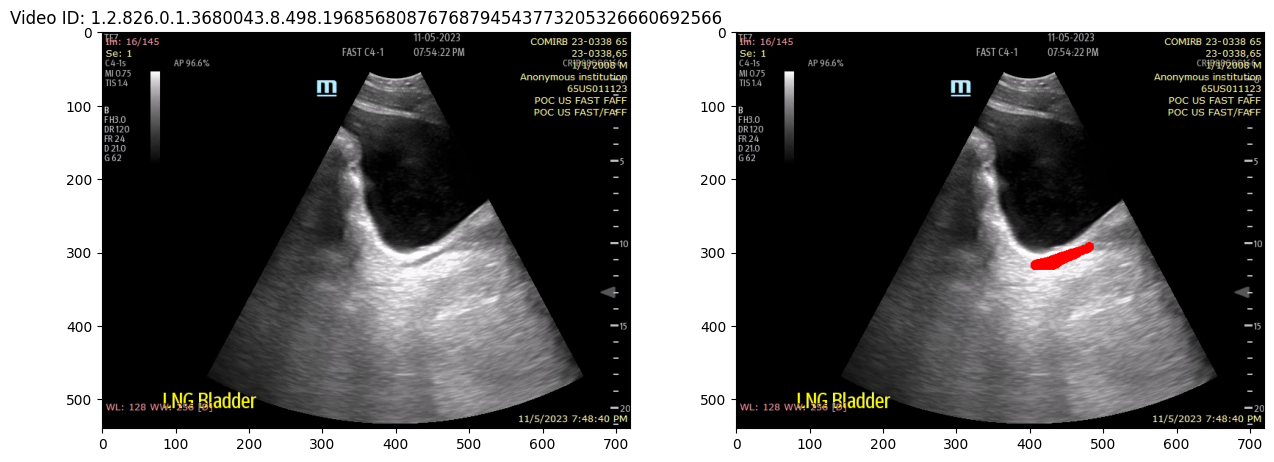

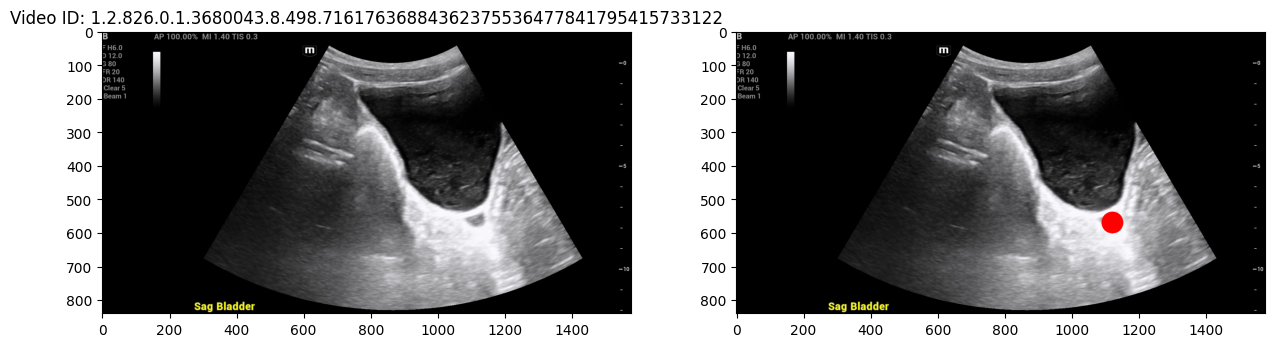

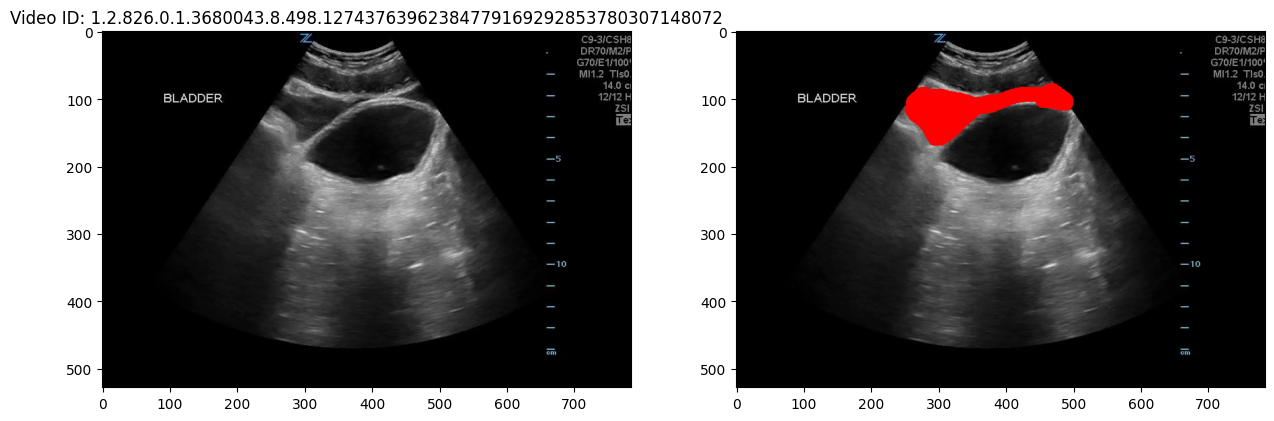

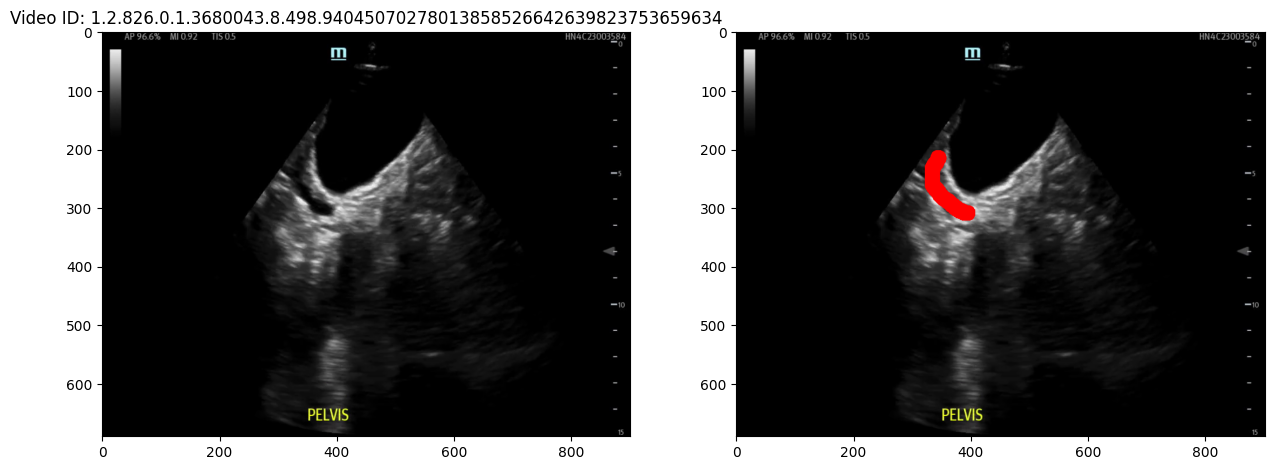

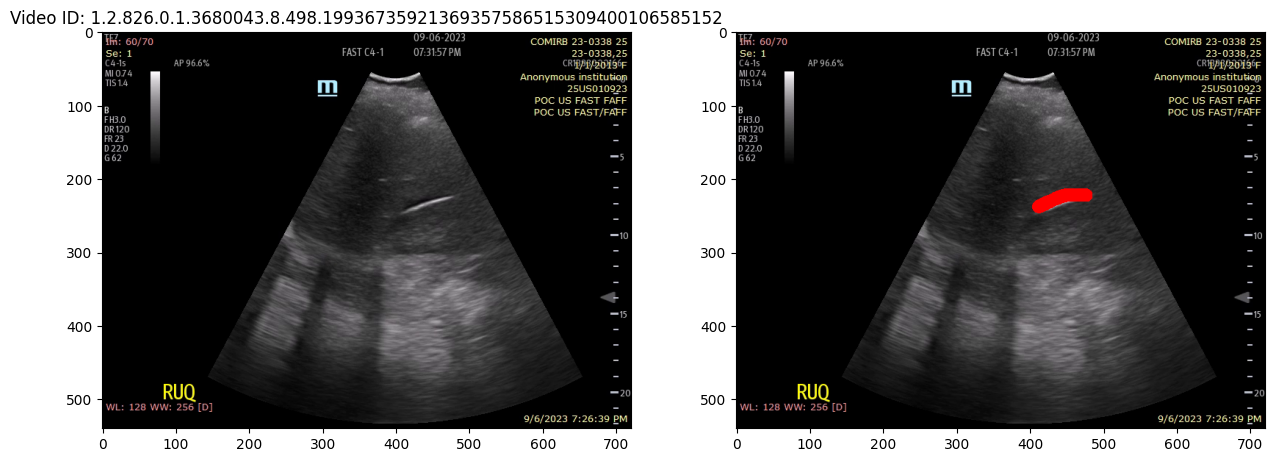

In [2]:

# Display selected annotations
for _, row in random_annotations.iterrows():
    display_annotation(row)

In [48]:
import cv2
import numpy as np
import os

# Parameters for Lucas-Kanade optical flow
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Parameters for ShiTomasi corner detection
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

def sort_points(points):
    # Calculate the centroid of the points
    center = np.mean(points, axis=0)
    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])
    return points[np.argsort(angles)]

def track_frames(cap, start_frame, end_frame, p0, initial_mask, forward=True):
    frames = []

    step = 1 if forward else -1
    frame_idx = start_frame

    old_frame = None
    old_gray = None

    while (forward and frame_idx <= end_frame) or (not forward and frame_idx >= 1):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            break

        if old_frame is None:
            old_frame = frame
            old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
            if initial_mask.shape != old_gray.shape:
                initial_mask = cv2.resize(initial_mask, (old_gray.shape[1], old_gray.shape[0]), interpolation=cv2.INTER_NEAREST)
            p0 = cv2.goodFeaturesToTrack(old_gray, mask=initial_mask, **feature_params)
            frame_idx += step
            continue

        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        if p1 is None or st is None:
            print(f"Failed to compute optical flow at frame {frame_idx}.")
            break

        good_new = p1[st == 1]
        good_old = p0[st == 1]

        mask = np.zeros_like(frame_gray)
        if len(good_new) > 0:
            points = good_new.reshape(-1, 2).astype(np.int32)
            sorted_points = sort_points(points)
            cv2.fillPoly(mask, [sorted_points], 255)

        mask_3ch = cv2.merge([mask, np.zeros_like(mask), np.zeros_like(mask)])  # Blue mask
        annotated_frame = cv2.addWeighted(frame, 1, mask_3ch, 0.5, 0)
        frames.append(annotated_frame)

        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)
        frame_idx += step

    return frames

def save_combined_video(video_path, output_video_path, initial_mask, frame_number):
    cap = cv2.VideoCapture(video_path)
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Track backward from the annotated frame to the start
    backward_frames = track_frames(cap, frame_number, 1, None, initial_mask, forward=False)
    # Track forward from the annotated frame to the end
    forward_frames = track_frames(cap, frame_number, total_frames - 1, None, initial_mask, forward=True)
    
    # Combine backward and forward frames, ensuring they are in the correct order
    combined_frames = backward_frames[::-1] + forward_frames[1:]  # Reverse backward frames and skip the duplicated annotated frame
    
    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Define the codec and create VideoWriter object
    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
    
    for frame in combined_frames:
        out.write(frame)
    
    cap.release()
    out.release()
    print(f"Video saved at {output_video_path}")

def track_and_save_masks_as_video(annotation, output_dir):
    video_id = annotation['SeriesInstanceUID']
    video_path = annotation['video_path']
    frame_number = int(annotation['frameNumber'])
    foreground = annotation['data']['foreground']
    
    # Read the first frame to get the size
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if not ret:
        print(f"Failed to read the frame number {frame_number} from the video.")
        return
    cap.release()
    
    # Initialize mask from polygons with the correct size
    initial_mask = polygons_to_mask(foreground, frame.shape[0], frame.shape[1])
    
    # Perform tracking and save masked frames as masked_{video_id}.mp4
    output_video_path = os.path.join(output_dir, f'masked_{video_id}.mp4')
    save_combined_video(video_path, output_video_path, initial_mask, frame_number)

# Apply the tracking function to each annotation in random_annotations
output_base_dir = 'tracked_videos'  # Base directory to save the tracked videos
os.makedirs(output_base_dir, exist_ok=True)

for index, annotation in random_annotations.iterrows():
    output_dir = os.path.join(output_base_dir, f'annotation_{index}')
    os.makedirs(output_dir, exist_ok=True)
    track_and_save_masks_as_video(annotation, output_dir)

print("Tracking and saving videos completed.")


Video saved at tracked_videos/annotation_824/masked_1.2.826.0.1.3680043.8.498.19685680876768794543773205326660692566.mp4
Video saved at tracked_videos/annotation_999/masked_1.2.826.0.1.3680043.8.498.71617636884362375536477841795415733122.mp4
Video saved at tracked_videos/annotation_935/masked_1.2.826.0.1.3680043.8.498.12743763962384779169292853780307148072.mp4
Failed to compute optical flow at frame 104.
Video saved at tracked_videos/annotation_1022/masked_1.2.826.0.1.3680043.8.498.94045070278013858526642639823753659634.mp4
Video saved at tracked_videos/annotation_963/masked_1.2.826.0.1.3680043.8.498.19936735921369357586515309400106585152.mp4
Tracking and saving videos completed.


In [65]:
import cv2
import numpy as np
import os

# Parameters for Lucas-Kanade optical flow
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Parameters for ShiTomasi corner detection
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

# Minimum number of good points to continue tracking
MIN_GOOD_POINTS = 8
MIN_CONFIDENCE = 0.9
MIN_MASK_AREA = 500  # Define your minimum mask area

def sort_points(points):
    center = np.mean(points, axis=0)
    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])
    return points[np.argsort(angles)]

def track_frames(cap, start_frame, end_frame, p0, initial_mask, forward=True, save_dir=None):
    frames = []
    step = 1 if forward else -1
    dir = "forward" if forward else "backward"
    frame_idx = start_frame
    old_frame = None
    old_gray = None

    while (forward and frame_idx <= end_frame) or (not forward and frame_idx >= 1):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            break

        if old_frame is None:
            old_frame = frame
            old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
            if initial_mask.shape != old_gray.shape:
                initial_mask = cv2.resize(initial_mask, (old_gray.shape[1], old_gray.shape[0]), interpolation=cv2.INTER_NEAREST)
            p0 = cv2.goodFeaturesToTrack(old_gray, mask=initial_mask, **feature_params)
            frame_idx += step
            continue

        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        if p1 is None or st is None:
            print(f"Stopping {dir} tracking at frame {frame_idx} due to optical flow calculation failure.")
            break

        high_confidence_idx = np.where(st >= MIN_CONFIDENCE)[0]
        good_new = p1[high_confidence_idx]
        good_old = p0[high_confidence_idx]

        if len(good_new) < MIN_GOOD_POINTS:
            print(f"Stopping {dir} tracking at frame {frame_idx} due to insufficient good points.")
            break

        mask = np.zeros_like(frame_gray)
        if len(good_new) > 0:
            points = good_new.reshape(-1, 2).astype(np.int32)
            sorted_points = sort_points(points)
            cv2.fillPoly(mask, [sorted_points], 255)

            if cv2.countNonZero(mask) < MIN_MASK_AREA:
                print(f"Stopping {dir} tracking at frame {frame_idx} due to mask area below threshold.")
                break

        if save_dir:
            mask_filename = os.path.join(save_dir, f"mask_{frame_idx:04d}.png")
            cv2.imwrite(mask_filename, mask)
        
        mask_3ch = cv2.merge([mask, np.zeros_like(mask), np.zeros_like(mask)])  # Blue mask
        annotated_frame = cv2.addWeighted(frame, 1, mask_3ch, 0.5, 0)
        frames.append((frame_idx, annotated_frame))

        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)
        frame_idx += step

    return frames

def save_combined_video(video_path, output_video_path, initial_mask, frame_number, save_dir=None):
    cap = cv2.VideoCapture(video_path)
    print(save_dir)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Track backward from the annotated frame to the start
    backward_frames = track_frames(cap, frame_number, 1, None, initial_mask, forward=False, save_dir=save_dir)
    # Track forward from the annotated frame to the end
    forward_frames = track_frames(cap, frame_number, total_frames - 1, None, initial_mask, forward=True, save_dir=save_dir)
    
    # Combine backward and forward frames, ensuring they are in the correct order
    combined_frames = backward_frames[::-1] + forward_frames[1:]  # Reverse backward frames and skip the duplicated annotated frame

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Define the codec and create VideoWriter object
    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
    
    # Write combined frames to the video
    if combined_frames:
        for frame_idx, frame in combined_frames:
            out.write(frame)
        
        # Include unmasked frames after early stopping
        if len(combined_frames) < total_frames:
            cap.set(cv2.CAP_PROP_POS_FRAMES, combined_frames[-1][0] + 1)
            for _ in range(len(combined_frames), total_frames):
                ret, frame = cap.read()
                if not ret:
                    break
                out.write(frame)
    else:
        # If combined_frames is empty, write the original frames
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        for _ in range(total_frames):
            ret, frame = cap.read()
            if not ret:
                break
            out.write(frame)
    
    cap.release()
    out.release()
    print(f"Video saved at {output_video_path}")

def track_and_save_masks_as_video(annotation, output_dir):
    video_id = annotation['SeriesInstanceUID']
    video_path = annotation['video_path']
    frame_number = int(annotation['frameNumber'])
    foreground = annotation['data']['foreground']

    # Announce the start of tracking
    print(f"Video: {video_id}; Frame: {frame_number}...")
    
    # Read the first frame to get the size
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if not ret:
        print(f"Failed to read the frame number {frame_number} from the video.")
        return
    cap.release()
    
    # Initialize mask from polygons with the correct size
    initial_mask = polygons_to_mask(foreground, frame.shape[0], frame.shape[1])
    
    # Perform tracking and save masked frames as masked_{video_id}.mp4
    output_video_path = os.path.join(output_dir, f'masked_{video_id}.mp4')
    save_dir = os.path.join(output_dir, 'masks')
    os.makedirs(save_dir, exist_ok=True)
    save_combined_video(video_path, output_video_path, initial_mask, frame_number, save_dir=save_dir)

# Apply the tracking function to each annotation in random_annotations
output_base_dir = 'tracked_videos'  # Base directory to save the tracked videos
os.makedirs(output_base_dir, exist_ok=True)

for index, annotation in random_annotations.iterrows():
    output_dir = os.path.join(output_base_dir, f'annotation_{index}')
    os.makedirs(output_dir, exist_ok=True)
    track_and_save_masks_as_video(annotation, output_dir)

print("Tracking and saving videos completed.")


Video: 1.2.826.0.1.3680043.8.498.19685680876768794543773205326660692566; Frame: 15...
tracked_videos/annotation_824/masks
Stopping forward tracking at frame 23 due to mask area below threshold.
Video saved at tracked_videos/annotation_824/masked_1.2.826.0.1.3680043.8.498.19685680876768794543773205326660692566.mp4
Video: 1.2.826.0.1.3680043.8.498.71617636884362375536477841795415733122; Frame: 86...
tracked_videos/annotation_999/masks
Stopping backward tracking at frame 85 due to insufficient good points.
Stopping forward tracking at frame 87 due to insufficient good points.
Video saved at tracked_videos/annotation_999/masked_1.2.826.0.1.3680043.8.498.71617636884362375536477841795415733122.mp4
Video: 1.2.826.0.1.3680043.8.498.12743763962384779169292853780307148072; Frame: 35...
tracked_videos/annotation_935/masks
Video saved at tracked_videos/annotation_935/masked_1.2.826.0.1.3680043.8.498.12743763962384779169292853780307148072.mp4
Video: 1.2.826.0.1.3680043.8.498.94045070278013858526642

In [ ]:
# Define feature parameters for goodFeaturesToTrack
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

# Define parameters for Lucas-Kanade optical flow
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

def track_free_fluid(annotation):
    video_path = annotation['video_path']
    frame_number = int(annotation['frameNumber'])
    foreground = annotation['data']['foreground']

    print(f"Processing video: {video_path}, frame: {frame_number}")

    cap = cv2.VideoCapture(video_path)

    # Move to the annotated frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, old_frame = cap.read()

    if not ret:
        print(f"Failed to read the frame number {frame_number} from the video.")
        return

    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

    # Combine all shapes into a single list of points
    all_points = [point for shape in foreground for point in shape]
    p0 = np.array(all_points, np.float32).reshape(-1, 1, 2)

    # print(f"Initial points for tracking (p0): {p0}")

    mask = np.zeros_like(old_frame)

    while True:
        ret, frame = cap.read()
        if not ret:
            print("No more frames to read or end of video reached.")
            break

        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        if p1 is None or st is None:
            print("Optical flow failed or no features found.")
            break

        # Select good points
        good_new = p1[st == 1]
        good_old = p0[st == 1]

        print(f"New good points: {good_new}")
        print(f"Old good points: {good_old}")

        if len(good_new) == 0 or len(good_old) == 0:
            print("No good points found.")
            break

        # Draw the tracks
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            print(f"Drawing line: start=({a}, {b}), end=({c}, {d})")
            a, b, c, d = int(a), int(b), int(c), int(d)
            frame = cv2.line(frame, (a, b), (c, d), (0, 255, 0), 2)
            frame = cv2.circle(frame, (a, b), 5, (0, 255, 0), -1)

        img = frame

        cv2.imshow('frame', img)
        if cv2.waitKey(30) & 0xFF == 27:
            print("Stopped by user.")
            break

        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)

    cap.release()
    cv2.destroyAllWindows()

# Example usage
for _, annotation in random_annotations.iterrows():
    display_annotation(annotation)
    track_free_fluid(annotation)
    break


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define feature parameters for goodFeaturesToTrack
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

# Define parameters for Lucas-Kanade optical flow
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Confidence threshold for dropping points with high error
confidence_threshold = 1.0

def track_free_fluid(annotation):
    video_path = annotation['video_path']
    frame_number = int(annotation['frameNumber'])
    foreground = annotation['data']['foreground']

    print(f"Processing video: {video_path}, frame: {frame_number}")

    cap = cv2.VideoCapture(video_path)

    # Move to the annotated frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, old_frame = cap.read()

    if not ret:
        print(f"Failed to read the frame number {frame_number} from the video.")
        return

    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

    # Combine all shapes into a single list of points
    all_points = [point for shape in foreground for point in shape]
    p0 = np.array(all_points, np.float32).reshape(-1, 1, 2)

    # print(f"Initial points for tracking (p0): {p0}")

    mask = np.zeros_like(old_frame)

    while True:
        ret, frame = cap.read()
        if not ret:
            print("No more frames to read or end of video reached.")
            break

        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        if p1 is None or st is None:
            print("Optical flow failed or no features found.")
            break

        # Select good points
        good_new = p1[st == 1]
        good_old = p0[st == 1]
        errors = err[st == 1]

        print(f"New good points: {good_new}")
        print(f"Old good points: {good_old}")

        if len(good_new) == 0 or len(good_old) == 0:
            print("No good points found.")
            break

        # Filter out points with high error
        valid_new = []
        valid_old = []
        for new, old, e in zip(good_new, good_old, errors):
            if e < confidence_threshold:
                valid_new.append(new)
                valid_old.append(old)
                a, b = new.ravel()
                c, d = old.ravel()
                frame = cv2.line(frame, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
                frame = cv2.circle(frame, (int(a), int(b)), 5, (0, 255, 0), -1)

        if len(valid_new) == 0 or len(valid_old) == 0:
            print("No valid points found.")
            break

        good_new = np.array(valid_new).reshape(-1, 1, 2)
        good_old = np.array(valid_old).reshape(-1, 1, 2)

        img = frame

        cv2.imshow('frame', img)
        if cv2.waitKey(30) & 0xFF == 27:
            print("Stopped by user.")
            break

        old_gray = frame_gray.copy()
        p0 = good_new

    cap.release()
    cv2.destroyAllWindows()

# Example usage
for _, annotation in random_annotations.iterrows():
    display_annotation(annotation)
    track_free_fluid(annotation)
    break
